In [15]:
import stumpy
from time import time
import os
import numpy as np
from tqdm import tqdm
import pandas as pd
from time import time
import matplotlib.pyplot as plt
import neurokit2 as nk
import os
# import argparse
from scipy.signal import find_peaks, filtfilt, convolve, hilbert, find_peaks, butter, buttord, sosfilt
from scipy.stats import skew
from typing import List, Dict, Any, Tuple, Union
import math
import copy
from scipy.spatial.distance import euclidean

def pad_sequences(seqs):
    largest_seq = max([len(s) for s in seqs])
    padded_seqs = np.zeros((len(seqs), largest_seq))
    for i,s in enumerate(seqs):
        padded_seqs[i, :len(s)] = s
        
    return padded_seqs

MIT_DATASET_PATH = "mit-bih-arrhythmia-database-1.0.0/"

In [9]:
import wfdb
def read_mit_ecg(subject):
    path = os.path.join(MIT_DATASET_PATH,subject)
    data = wfdb.rdsamp(path)[0][:,0]
    return nk.ecg_clean(data, sampling_rate=360)

In [23]:
def compute_pmp(ts, L, U, STEP, FREQ, caller, return_motifs = True, n_motifs = 3, return_anomalies = True, n_anomalies = 3):
    subseq_sizes = np.arange(L,U+1,STEP)
    print(f"Computing MP using windows from {L/FREQ}s to {U/FREQ}s varying by {STEP/FREQ}s")
    all_mp = []
    motifs = []
    anomalies = []
    return_something = return_anomalies or return_motifs
    for subseq_size in tqdm(subseq_sizes):
        start_time = time()
        mp_calc = caller(ts, subseq_size)
        end_time = time()
        all_mp.append(mp_calc)

        if return_something:
            sorted_indexes = mp_calc.argsort()
            if return_motifs:
                motifs.append(sorted_indexes[:n_motifs])
            if return_anomalies:
                anomalies.append(sorted_indexes[-n_anomalies:])

    motifs = np.array(motifs)
    anomalies = np.array(anomalies)
    all_mp = pad_sequences(all_mp)
    
    if not return_motifs and not return_anomalies:
        return all_mp
    else:
        result = {"pmp": all_mp}
        if return_anomalies:
            result["anomalies"] = anomalies
        if return_motifs:
            result["motifs"] = motifs
        return result

In [12]:
from os import walk

def load_or_run_stump_wrapper_mit(subject = None, return_index = False):
    # ---------------------
    def wrp(ts,m):
        mp_file_name = f"mps/ecg/mit/mp-{subject}-{m}"
        idx_file_name = f"mps/ecg/mit/idx-{subject}-{m}"
        
        try:
            if subject is None:
                msg = "identifier not informed. No cached result will be used"
                raise Exception(msg)

            mp = np.load(f"{mp_file_name}.npy", allow_pickle=True)
            index = np.load(f"{idx_file_name}.npy", allow_pickle=True)

        except Exception as e:
            # print(e)
            result = None

            result = stumpy.stump(ts,m=m)
            mp = result[:,0].ravel()
            index = result[:,1].ravel()
                
            if subject_id is not None:
                np.save(mp_file_name,mp)
                if not modified:
                    np.save(idx_file_name,index)


        if return_index:
            return mp, index
        else:
            return mp
    # ---------------------
        
    return wrp


#### Group motifs

In [13]:
from matplotlib.colors import TABLEAU_COLORS
from hdbscan import HDBSCAN
from sklearn.neighbors import NearestNeighbors

def simple_clustering(motifs, eps, min_samples):
    core_points = []
    for i,m in enumerate(motifs):
        dists = pd.Series(np.abs(motifs-m))
        n_neighbors = dists[dists <= eps].shape[0]
        if n_neighbors >= min_samples:
            core_points.append([m,i])
    
    return (np.array([p[0] for p in core_points]), np.array([p[1] for p in core_points]))
        

def group_and_plot_motifs(motifs, freq, L, U, STEP, eps_factor = 2, hierarchical = False, min_samples = 5, ax=plt):
    subseq_sizes = np.arange(L,U+1,STEP)/freq
    eps = eps_factor*freq
    labels = None
    core_points = None
    core_points_idx = None
    main_core_point = None
    core_points_sizes = None
    main_core_point_size = None
    if hierarchical:
        scan = HDBSCAN(min_samples=min_samples, cluster_selection_epsilon=eps, min_cluster_size=2, allow_single_cluster=True)
        labels = scan.fit(motifs.reshape(-1,1)).labels_
        non_outliers = labels != -1
        if non_outliers.shape[0] == 0:
            core_points = np.array([])
        else:
            core_points = motifs[non_outliers]
            core_points_idx = np.arange(motifs.shape[0])[non_outliers]
        
    else:
        # scan = DBSCAN(eps=eps, min_samples=min_samples)
        # labels = scan.fit_predict(motifs.reshape(-1,1))
        # core_points = scan.components_.ravel()
        # core_points_idx = scan.core_sample_indices_
        core_points, core_points_idx = simple_clustering(motifs, eps, min_samples)
        labels = np.array([0 if i in core_points_idx else -1 for i in range(len(motifs))])
    
    if core_points.shape[0] > 0:
        nn = NearestNeighbors(n_neighbors=1, radius=eps)
        nn.fit(motifs[:, np.newaxis])
        result,_ = nn.radius_neighbors(core_points[:,np.newaxis])
        cores_neigborhood = np.array([len(r) for r in result])
        if len(cores_neigborhood) > 0:
            cores_idx = np.argsort(cores_neigborhood)[::-1]
            core_points = core_points[cores_idx]
#             print(list(zip(core_points/freq,cores_neigborhood[cores_idx])))
            core_points_sizes = subseq_sizes[core_points_idx[cores_idx]]
            
            main_core_point = core_points[0]/freq
            main_core_point_size = core_points_sizes[0]
            
            ax.axvline(main_core_point,alpha=.5, label=f"Central core point: {np.round(main_core_point,2)}s")
            ax.axhline(main_core_point_size,alpha=.5, label=f"Central core point size: {main_core_point_size}s")
        
    (unique_labels, counts) = np.unique(labels, return_counts=True)

    for label, count, color in zip(unique_labels, counts, TABLEAU_COLORS):
        idx = labels == label
        ax.scatter(
            motifs[idx]/freq,
            subseq_sizes[idx],
            c=color if not label == -1 else 'k' ,
            label=f"{label} ({count})" if not label == -1 else f"Outliers ({count})"
        );
    ax.xlabel("Subsequence starting point (s)", fontsize=16)
    ax.ylabel("Subsequence size (s)", fontsize=16)
    ax.xticks(fontsize=16)
    ax.yticks(fontsize=16)
    ax.legend()
    
    return (core_points, core_points_sizes)

#### Motif distance

In [25]:
from tqdm import trange
def motif_distance(ts,motif_pos,subseq_size,
                   exclusion_size=None,
                   return_type=None,
                   corr=False,
                   n_dim = None
                  ):
    motif_pos = int(motif_pos)
    subseq_size = int(subseq_size)
    available_returns = {
        "mean": np.mean,
        "median": np.median
    }

    exclusion_size = exclusion_size if exclusion_size is not None else int(subseq_size/2)
    motif = ts[motif_pos:motif_pos+subseq_size]
    
    multidimensional = len(ts.shape) > 1 and ts.shape[1] > 1
    if multidimensional and n_dim is None:
        n_dim = ts.shape[1]
    
    distances = []
    for i in range(ts.shape[0] - subseq_size + 1):
        if i >= motif_pos - exclusion_size and i <= motif_pos + exclusion_size:
            continue
            
        ts_subseq = ts[i:i+subseq_size]
        metric_value = None
        if corr:
            if multidimensional:
                metric_value = np.array([np.corrcoef(m, s)[0,1] for m,s in zip(motif.T, ts_subseq.T)])
            else:
                metric_value = np.corrcoef(motif, ts_subseq)[0,1]
                
            metric_value = np.abs(metric_value)
        else:
            metric_value = np.linalg.norm(motif - ts_subseq, axis=0)
            #metric_value, _ = fastdtw(motif, ts_subseq, radius=1, dist=euclidean)
            
        if multidimensional:
            metric_value.sort()
            metric_value = metric_value[:n_dim].sum() if not corr else metric_value[:n_dim].mean()
            
        distances.append(metric_value)
            
    
    if return_type in available_returns:
        return available_returns[return_type](distances)
    elif return_type == "all":
        metric_name = "Corr." if corr else "Dist."
#         return {m: f(distances) for m,f in available_returns.items()}
        return pd.Series(distances).describe().to_frame().T\
                    .drop("count", axis=1)\
                    .rename(columns= lambda c: f"{metric_name} {c}").to_dict()
    else:
        return distances
    
def sumarize_motifs(ts, motifs_pos, subseqs_size, freq, full_ecg = None):
    sum_df = pd.DataFrame()
    for motif_pos, subseq_size in zip(motifs_pos, subseqs_size):
        ecg = full_ecg.split(motif_pos, motif_pos+int(subseq_size)) if full_ecg is not None else ECG(ts[motif_pos:motif_pos+int(subseq_size)], freq)
        dist_df = pd.DataFrame(motif_distance(ts,motif_pos,subseq_size, corr=False, return_type='all'), index=[0])
            #.rename(columns = lambda c: f"{c} distance")
        # corr_df = pd.DataFrame(motif_distance(ts,motif_pos,subseq_size, corr=True, return_type='all'), index=[0])
            #.rename(columns = lambda c: f"{c} correlation")
        df = pd.concat([dist_df], axis=1).iloc[:,:2]
        df.insert(0,"size", subseq_size/freq)
        df.insert(0,"start", motif_pos/freq)
        df.insert(3, "dist/sec", df["Dist. mean"]/df["size"])
        sum_df = pd.concat([sum_df,df.round(2).join(ecg.healthy_score(as_dataframe=True))])
        
    tbl = plt.table(cellText=sum_df.values, colLabels=sum_df.columns, loc='center')
    tbl.set_fontsize(20)
    tbl.scale(1, 4)
    plt.axis('off')
    # plt.title("Sumarizing metrics", fontsize=20)
    return sum_df
    

#### Motifs plot

In [16]:
def plot_ts(ts, freq, y_label="Signal"):
    time_idx = np.arange(0,len(ts)) / freq
    plt.plot(time_idx, ts)
    plt.ylabel(y_label, fontsize=16)
        
def plot_ts_motif(ts, motif_idx, motif_size, freq, y_label="Signal", ax = plt, ylim = None):
    motif_size = int(motif_size)
    margin = int(motif_size/2)
    start = max(motif_idx - margin, 0)
    end = min(motif_idx + motif_size + margin + 1,ts.shape[0])
    ts_sample = ts[start : end]
    time_idx = np.arange(start,end) / freq
    if len(ts.shape) == 1 or ts.shape[1] == 1:
        ax.plot(time_idx,ts_sample)
        ax.plot(time_idx[margin:-margin],ts_sample[margin:-margin],'r', label=f"Motif ({motif_size/freq}s)")
        ax.ylabel(y_label, fontsize=16)
        
    else:
        if not len(y_label) == ts.shape[1]:
            raise Exception("y_label should be an array with size equal to the time series dimension")
        for i,(line,label) in enumerate(zip(ts,y_label)):
            ax.subplot(ts.shape[1],1,i+1)
            ax.plot(time_idx,ts_sample[:,i])
            ax.plot(time_idx[margin:-margin],ts_sample[margin:-margin,i],'r', label=f"Motif ({motif_size/freq}s)")
            ax.ylabel(label, fontsize=16)
            
    ax.xticks(fontsize=16)
    ax.yticks(fontsize=16)
    ax.xlabel("Time (s)", fontsize=16)
    if ylim is not None:
        ax.ylim(ylim)
    ax.legend();
    

#### Wavelet transform

In [17]:
def rms(arr: List[float]) -> float:
    return np.sqrt((np.array(arr) ** 2).mean())

def wavelet_transform(channel_data, num, acl=False):
    gn = [-2, 2]
    hn = [1/8, 3/8, 3/8, 1/8]

    for iteration in range(num):
        wavelet_transformed_data = convolve(channel_data, gn)

        if iteration == 1:
            wavelet_transformed_data_1 = copy.deepcopy(wavelet_transformed_data)
        elif iteration == 2:
            wavelet_transformed_data_2 = copy.deepcopy(wavelet_transformed_data)

        for iter_gn in range(int(len(gn) / 2)):
            wavelet_transformed_data = np.delete(wavelet_transformed_data, 0)
            wavelet_transformed_data = np.delete(wavelet_transformed_data, len(wavelet_transformed_data) - 1)

        channel_data = convolve(channel_data, hn)

        for iter_hn in range(int(len(hn) / 2)):
            channel_data = np.delete(channel_data, 0)
            channel_data = np.delete(channel_data, len(channel_data) - 1)

        new_gn = []
        new_hn = []

        for iter_gn in range(len(gn)):
            new_gn.append(gn[iter_gn])
            new_gn.append(0)
        gn = new_gn

        for iter_hn in range(len(hn)):
            new_hn.append(hn[iter_hn])
            new_hn.append(0)
        hn = new_hn

    if acl:
        return wavelet_transformed_data, wavelet_transformed_data_1, wavelet_transformed_data_2
    else:
        return wavelet_transformed_data
    
from tqdm import tqdm
def wavelet_martinez_get_info(sample: List[float], f_samp: int) -> List[Dict[str, Any]]:
    """
    Extract information from an ECG sample.

    Args:
        sample (List[float]): List of ECG sample values.
        f_samp (int): Sampling frequency.

    Returns:
        List[Dict[str, Any]]: List of dictionaries containing extracted information for each channel.
    """
    
    qrs_peaks_sample = []
    qrs_on_sample = []
    qrs_off_sample = []
    t_peaks_sample = []
    t_on_sample = []
    t_off_sample = []
    p_peaks_sample = []
    p_on_sample = []
    p_off_sample = []

    print("Iterating over chanels")
    for iter_channel in range(1):
        wavelet = []
        threshold = []
        max_lines_pos = [[], [], [] , []]
        max_lines_neg = [[], [], [], []]
        for scale in range(1, 5):
            wavelet_scale = wavelet_transform(sample[iter_channel], scale)
            wavelet.append(wavelet_scale)
            if scale != 4:
                threshold_scale = rms(wavelet_scale) 
                threshold.append(threshold_scale)
            else:
                threshold_scale = 0.5*rms(wavelet_scale)
                threshold.append(threshold_scale)
    
        neighbourhood = int(0.12*f_samp)

        max_line_4_pos, _ = find_peaks(wavelet[3], height = threshold[3], distance=2*neighbourhood)
        max_line_4_neg, _ = find_peaks(-wavelet[3], height = threshold[3], distance=2*neighbourhood)

        max_lines_pos[3].extend(max_line_4_pos)
        max_lines_neg[3].extend(max_line_4_neg)
        
        for max_line in max_lines_pos[3]:
            for scale in range(2, -1, -1):
                start = max_line-neighbourhood if max_line-neighbourhood >= 0 else 0
                end = max_line+neighbourhood if max_line+neighbourhood <= len(wavelet[scale]) - 1 else len(wavelet[scale]) - 1
                aux_max_line, _ = find_peaks(wavelet[scale][start:end], height = threshold[scale])
                if len(aux_max_line) == 0:
                    for aux in range(scale, -1, -1):
                        max_lines_pos[aux].extend([0])
                        break
                elif len(aux_max_line) == 1:
                    aux_max_line[0] = aux_max_line[0] + start
                    max_lines_pos[scale].extend(aux_max_line)
                elif len(aux_max_line) > 1:
                    marks = [value + start for value in aux_max_line]
                    values = [wavelet[scale][value + start] for value in aux_max_line]
                    max_value = np.argmax(values)
                    max_lines_pos[scale].extend([aux_max_line[max_value] + start])
            
        for max_line in max_lines_neg[3]:
            for scale in range(2, -1, -1):
                start = max_line-neighbourhood if max_line-neighbourhood >= 0 else 0
                end = max_line+neighbourhood if max_line+neighbourhood <= len(wavelet[scale]) - 1 else len(wavelet[scale]) - 1
                aux_max_line, _ = find_peaks(-wavelet[scale][start:end], height = threshold[scale])
                if len(aux_max_line) == 0:
                    for aux in range(scale, -1, -1):
                        max_lines_neg[aux].extend([0])
                        break
                elif len(aux_max_line) == 1:
                    aux_max_line[0] = aux_max_line[0] + start
                    max_lines_neg[scale].extend(aux_max_line)
                elif len(aux_max_line) > 1:
                    marks = [value + start for value in aux_max_line]
                    values = [wavelet[scale][value + start] for value in aux_max_line]
                    max_value = np.argmin(values)
                    max_lines_neg[scale].extend([aux_max_line[max_value] + start])

        # QRS DETECTION
                        
        possible_qrs_peaks_boundaries = []
        for marks in max_lines_pos[0]:
            if marks == 0:
                continue
            possible_qrs_peaks_boundaries.append(marks)
        for marks in max_lines_neg[0]:
            if marks == 0:
                continue
            possible_qrs_peaks_boundaries.append(marks)

        possible_qrs_peaks_boundaries = np.sort(possible_qrs_peaks_boundaries)

        removed_boundaries = []

        for index, boundarie in enumerate(possible_qrs_peaks_boundaries):
            if index == 0:
                if abs(possible_qrs_peaks_boundaries[index + 1] - boundarie) > neighbourhood:
                    removed_boundaries.append(boundarie)
            elif index == len(possible_qrs_peaks_boundaries) - 1:
                if abs(possible_qrs_peaks_boundaries[index - 1] - boundarie) > neighbourhood:
                    removed_boundaries.append(boundarie)
            else:
                if abs(possible_qrs_peaks_boundaries[index + 1] - boundarie) > neighbourhood and abs(possible_qrs_peaks_boundaries[index - 1] - boundarie) > neighbourhood:
                    removed_boundaries.append(boundarie)


        possible_qrs_peaks_boundaries = np.setdiff1d(possible_qrs_peaks_boundaries, removed_boundaries)

        qrs_peaks_channel = []
        qrs_on_channel = []
        qrs_off_channel = []

        for peak_boundarie in range(0, len(possible_qrs_peaks_boundaries), 2):
            try:
                qrs_peak_on = possible_qrs_peaks_boundaries[peak_boundarie]
                qrs_peak_off = possible_qrs_peaks_boundaries[peak_boundarie + 1]
                
                # QRS_PEAK
                zero_crossings = np.where(np.diff(np.sign(wavelet[0][qrs_peak_on:qrs_peak_off])))[0]
                if len(zero_crossings) > 0:
                    qrs_peak = zero_crossings[0] + qrs_peak_on
                else:
                    qrs_peak = np.argmax(abs(sample[iter_channel][qrs_peak_on:qrs_peak_off])) + qrs_peak_on

                # QRS ON
                qrs_on_search_on = qrs_peak_on - int(neighbourhood/2) if qrs_peak_on - int(neighbourhood/2) > 0 else 0
                qrs_on_search_off = qrs_peak_on
                qrs_on_search_window = wavelet[3][qrs_on_search_on:qrs_on_search_off]
                possible_qrs_on, _ = find_peaks(abs(qrs_on_search_window))
                if len(possible_qrs_on) > 0:
                    values = [abs(qrs_on_search_window[value]) for value in possible_qrs_on]
                    ref_peak = possible_qrs_on[np.argmax(values)] + qrs_on_search_on - 1
                    qrs_on = ref_peak
                    while ((abs(wavelet[3][qrs_on]) <= abs(wavelet[3][qrs_on + 1])) or (abs(wavelet[3][qrs_on]) >= 0.1*abs(wavelet[3][ref_peak]))) and qrs_on > qrs_on_search_on:
                        qrs_on = qrs_on - 1
                else:
                    qrs_on = int((qrs_on_search_off - qrs_on_search_on)/4) + qrs_on_search_on if int((qrs_on_search_off - qrs_on_search_on)/4) + qrs_on_search_on > 0 else 0

                # QRS OFF
                qrs_off_search_on = qrs_peak_off
                qrs_off_search_off = qrs_peak_off + int(neighbourhood/2) if qrs_peak_off + int(neighbourhood/2) < len(wavelet[1]) else len(wavelet[1]) - 1
                qrs_off_search_window = wavelet[3][qrs_off_search_on:qrs_off_search_off]
                possible_qrs_off, _ = find_peaks(abs(qrs_off_search_window))
                if len(possible_qrs_off) > 0:
                    values = [abs(qrs_off_search_window[value]) for value in possible_qrs_off]
                    ref_peak = possible_qrs_off[np.argmax(values)] + qrs_off_search_on + 1
                    qrs_off = ref_peak
                    while ((abs(wavelet[3][qrs_off]) <= abs(wavelet[3][qrs_off - 1])) or (abs(wavelet[3][qrs_off]) >= 0.3*abs(wavelet[3][ref_peak]))) and qrs_off <= qrs_off_search_off:
                        qrs_off = qrs_off + 1
                else:
                    qrs_off = int((qrs_off_search_off - qrs_off_search_on)/4)*3 + qrs_off_search_on

                qrs_peaks_channel.append(qrs_peak)
                qrs_on_channel.append(qrs_on)
                qrs_off_channel.append(qrs_off)
                
            except Exception as e:
                continue

        # T DETECTION

        t_peaks_channel = []
        t_on_channel = []
        t_off_channel = []

        rr_interval_on_channel = qrs_off_channel[:-1]
        rr_interval_off_channel = qrs_on_channel[1:]
        wavelet.append(wavelet_transform(sample[iter_channel], 5))

        for rr_interval in range(len(rr_interval_on_channel)):
            try:
                rr_on = rr_interval_on_channel[rr_interval]
                rr_off = rr_interval_off_channel[rr_interval]
                t_range_on = rr_on
                t_range_off = rr_off - int((rr_off - rr_on)/2)

                t_threshold = 0.25*rms(wavelet[3][rr_on:rr_off])

                check_T, _ = find_peaks(abs(wavelet[3][t_range_on:t_range_off]), height=t_threshold)
                has_T = False

                if len(check_T) >= 2:
                    has_T = True

                if has_T == True:
                    t_threshold_peak = 0.125*max(abs(wavelet[3][t_range_on:t_range_off]))
                    possible_t_peaks, _ = find_peaks(abs(wavelet[3][t_range_on:t_range_off]), height=t_threshold_peak)
                    possible_t_peaks_pairs = []

                    for index, peak in enumerate(possible_t_peaks):
                        if index != len(possible_t_peaks) - 1:
                            peak_start = t_range_on + possible_t_peaks[index]
                            peak_end = t_range_on + possible_t_peaks[index+1]
                            if len(np.where(np.diff(np.sign(wavelet[3][peak_start:peak_end])))[0]) > 0 and (np.sign(wavelet[3][peak_start]) != np.sign(wavelet[3][peak_end])):
                                possible_t_peaks_pairs.append((peak_start, peak_end))

                    if len(possible_t_peaks_pairs) == 0:
                        t_threshold_peak = 0.125*max(abs(wavelet[4][t_range_on:t_range_off]))
                        possible_t_peaks_2, _ = find_peaks(abs(wavelet[4][t_range_on:t_range_off]), height=t_threshold_peak)
                        possible_t_peaks_2_pairs = []
                        for index, peak in enumerate(possible_t_peaks_2):
                            if index != len(possible_t_peaks_2) - 1:
                                peak_start = t_range_on + possible_t_peaks_2[index]
                                peak_end = t_range_on + possible_t_peaks_2[index+1]
                                if len(np.where(np.diff(np.sign(wavelet[4][peak_start:peak_end])))[0]) > 0 and (np.sign(wavelet[4][peak_start]) != np.sign(wavelet[4][peak_end])):
                                    possible_t_peaks_2_pairs.append((peak_start, peak_end))

                        pair_amplitudes = [abs(wavelet[4][pair[0]] - wavelet[4][pair[1]]) for pair in possible_t_peaks_2_pairs]
                        best_t_pair = np.argmax(pair_amplitudes)
                        best_t_pair = possible_t_peaks_2_pairs[best_t_pair]
                        t_scale = 4

                    else:
                        pair_amplitudes = [abs(wavelet[3][pair[0]] - wavelet[3][pair[1]]) for pair in possible_t_peaks_pairs]
    
                        best_t_pair = np.argmax(pair_amplitudes)
                        best_t_pair = possible_t_peaks_pairs[best_t_pair]
                        t_scale = 3

                    # T PEAK
                    if has_T == True:
                        zero_crossings = np.where(np.diff(np.sign(wavelet[2][best_t_pair[0]:best_t_pair[1]])))[0]
                        if len(zero_crossings) == 1:
                            t_peak = zero_crossings[0] + best_t_pair[0]
                            
                        elif len(zero_crossings) > 1:
                            t_peak = zero_crossings[0] + best_t_pair[0]

                        else:
                            zero_crossings = np.where(np.diff(np.sign(wavelet[t_scale][best_t_pair[0]:best_t_pair[1]])))[0]
                            if len(zero_crossings) > 0:
                                t_peak = zero_crossings[0] + best_t_pair[0]
                            else:
                                t_peak = best_t_pair[0] + int((best_t_pair[1] - best_t_pair[0])/2)

                        # T ON
                        neighbourhood_t = int(0.14*f_samp)
                        t_peak_on = best_t_pair[0]
                        t_on_search_on = t_peak_on - int(neighbourhood_t/2) if t_peak_on - int(neighbourhood_t/2) > t_range_on else t_range_on
                        t_on_search_off = t_peak_on
                        t_on_search_window = wavelet[3][t_on_search_on:t_on_search_off]
                        possible_t_on, _ = find_peaks(abs(t_on_search_window))
                        if len(possible_t_on) > 0:
                            values = [abs(t_on_search_window[value]) for value in possible_t_on]
                            ref_peak = possible_t_on[np.argmax(values)] + t_on_search_on - 1
                            t_on = ref_peak
                            while ((abs(wavelet[3][t_on]) <= abs(wavelet[3][t_on + 1])) or (abs(wavelet[3][t_on]) >= 0.1*abs(wavelet[3][ref_peak]))) and t_on >= t_on_search_on:
                                t_on = t_on - 1
                        else:
                            t_on = int((t_on_search_off - t_on_search_on)/4) + t_on_search_on

                        # T OFF
                        t_peak_off = best_t_pair[1]
                        t_off_search_on = t_peak_off
                        t_off_search_off = t_peak_off + int(neighbourhood_t/2) if t_peak_off + int(neighbourhood_t/2) < t_range_off else t_range_off
                        t_off_search_window = wavelet[3][t_off_search_on:t_off_search_off]
                        possible_t_off, _ = find_peaks(abs(t_off_search_window))

                        if len(possible_t_off) > 0:
                            values = [abs(t_off_search_window[value]) for value in possible_t_off]
                            ref_peak = possible_t_off[np.argmax(values)] + t_off_search_on + 1
                            t_off = ref_peak
                            while ((abs(wavelet[3][t_off]) <= abs(wavelet[3][t_off - 1])) or (abs(wavelet[3][t_off]) >= 0.3*abs(wavelet[3][ref_peak]))) and t_off <= t_off_search_off:
                                t_off = t_off + 1
                        else:
                            t_off = int((t_off_search_off - t_off_search_on)/4)*3 + t_off_search_on

                        t_peaks_channel.append(t_peak)
                        t_on_channel.append(t_on)
                        t_off_channel.append(t_off)
            except Exception as e:
                continue
            
        # P DETECTION

        p_peaks_channel = []
        p_on_channel = []
        p_off_channel = []

        for rr_interval in range(len(rr_interval_on_channel)):
            try:
                rr_on = rr_interval_on_channel[rr_interval]
                rr_off = rr_interval_off_channel[rr_interval]
                p_range_on = rr_on + int((rr_off - rr_on)/2)
                p_range_off = rr_off

                if abs(wavelet[3][p_range_off]) > 0.1*max(abs(wavelet[3])):
                    while(abs(wavelet[3][p_range_off]) < abs(wavelet[3][p_range_off + 1])):
                        p_range_off = p_range_off - 1

                p_threshold = 0.02*rms(wavelet[3][rr_on:rr_off])

                check_P, _ = find_peaks(abs(wavelet[3][p_range_on:p_range_off]), height=p_threshold)
                has_P = False

                if len(check_P) >= 2:
                    has_P = True
                
                # if rr_interval == 2:
                #     print(has_P)

                if has_P == True:
                    p_threshold_peak = 0.125*max(abs(wavelet[3][p_range_on:p_range_off]))
                    possible_p_peaks, _ = find_peaks(abs(wavelet[3][p_range_on:p_range_off]), height=p_threshold_peak)
                    possible_p_peaks_pairs = []

                    for index, peak in enumerate(possible_p_peaks):
                        if index != len(possible_p_peaks) - 1:
                            peak_start = p_range_on + possible_p_peaks[index]
                            peak_end = p_range_on + possible_p_peaks[index+1]
                            if len(np.where(np.diff(np.sign(wavelet[3][peak_start:peak_end])))[0]) > 0 and (np.sign(wavelet[3][peak_start]) != np.sign(wavelet[3][peak_end])) and peak_end - peak_start < f_samp*0.08:
                                possible_p_peaks_pairs.append((peak_start, peak_end))

                    if len(possible_p_peaks_pairs) == 0:
                        p_threshold_peak = 0.125*max(abs(wavelet[4][p_range_on:p_range_off]))
                        possible_p_peaks_2, _ = find_peaks(abs(wavelet[4][p_range_on:p_range_off]), height=p_threshold_peak)
                        possible_p_peaks_2_pairs = []
                        for index, peak in enumerate(possible_p_peaks_2):
                            if index != len(possible_p_peaks_2) - 1:
                                peak_start = p_range_on + possible_p_peaks_2[index]
                                peak_end = p_range_on + possible_p_peaks_2[index+1]
                                if len(np.where(np.diff(np.sign(wavelet[4][peak_start:peak_end])))[0]) > 0 and (np.sign(wavelet[4][peak_start]) != np.sign(wavelet[4][peak_end])):
                                    possible_p_peaks_2_pairs.append((peak_start, peak_end))
                        pair_amplitudes = [abs(wavelet[4][pair[0]] - wavelet[4][pair[1]]) for pair in possible_p_peaks_2_pairs]
                        best_p_pair = np.argmax(pair_amplitudes)
                        best_p_pair = possible_p_peaks_2_pairs[best_p_pair]
                        p_scale = 4

                    else:
                        pair_amplitudes = [abs(wavelet[3][pair[0]] - wavelet[3][pair[1]]) for pair in possible_p_peaks_pairs]
                        best_p_pair = np.argmax(pair_amplitudes)
                        best_p_pair = possible_p_peaks_pairs[best_p_pair]
                        p_scale = 3

                    # P PEAK
                    
                    if has_P == True:
                        zero_crossings = np.where(np.diff(np.sign(wavelet[2][best_p_pair[0]:best_p_pair[1]])))[0]
                        if len(zero_crossings) == 1:
                            p_peak = zero_crossings[0] + best_p_pair[0]
                            
                        elif len(zero_crossings) > 1:
                            p_peak = zero_crossings[0] + best_p_pair[0]

                        else:
                            zero_crossings = np.where(np.diff(np.sign(wavelet[p_scale][best_p_pair[0]:best_p_pair[1]])))[0]
                            if len(zero_crossings) > 0:
                                p_peak = zero_crossings[0] + best_p_pair[0]
                            else:
                                p_peak = best_p_pair[0] + int((best_p_pair[1] - best_p_pair[0])/2)

                        # P ON
                        p_peak_on = best_p_pair[0]
                        p_on_search_on = p_peak_on - int(neighbourhood/2) if p_peak_on - int(neighbourhood/2) > p_range_on else p_range_on
                        p_on_search_off = p_peak_on
                        p_on_search_window = wavelet[3][p_on_search_on:p_on_search_off]
                        possible_p_on, _ = find_peaks(abs(p_on_search_window), height = [0, 0.5*abs(wavelet[4][p_peak_on])])
                        if len(possible_p_on) > 0:
                            values = [abs(p_on_search_window[value]) for value in possible_p_on]
                            ref_peak = possible_p_on[np.argmax(values)] + p_on_search_on - 1
                            p_on = ref_peak
                            while ((abs(wavelet[3][p_on]) <= abs(wavelet[3][p_on + 1])) or (abs(wavelet[3][p_on]) >= 0.1*abs(wavelet[3][ref_peak]))) and p_on >= p_on_search_on:
                                p_on = p_on - 1
                        else:
                            p_on = int((p_on_search_off - p_on_search_on)/4) + p_on_search_on

                        # P OFF
                        p_peak_off = best_p_pair[1]
                        p_off_search_on = p_peak_off
                        p_off_search_off = p_peak_off + int(neighbourhood/2) if p_peak_off + int(neighbourhood/2) < p_range_off else p_range_off
                        p_off_search_window = wavelet[2][p_off_search_on:p_off_search_off]
                        possible_p_off, _ = find_peaks(abs(p_off_search_window), height = [0, 0.9*abs(wavelet[4][p_peak_off])])
                        if len(possible_p_off) > 0:
                            values = [abs(p_off_search_window[value]) for value in possible_p_off]
                            ref_peak = possible_p_off[np.argmax(values)] + p_off_search_on + 1
                            p_off = ref_peak
                            while ((abs(wavelet[3][p_off]) <= abs(wavelet[3][p_off - 1])) or (abs(wavelet[3][p_off]) >= 0.3*abs(wavelet[3][ref_peak]))) and p_off <= p_off_search_off:
                                p_off = p_off + 1
                        else:
                            p_off = int((p_off_search_off - p_off_search_on)/4)*3 + p_off_search_on

                        p_peaks_channel.append(p_peak)
                        p_on_channel.append(p_on)
                        p_off_channel.append(p_off)
            except Exception as e:
                continue

            p_peaks_sample.append(p_peaks_channel)
            p_on_sample.append(p_on_channel)
            p_off_sample.append(p_off_channel)
            qrs_peaks_sample.append(qrs_peaks_channel)
            qrs_on_sample.append(qrs_on_channel)
            qrs_off_sample.append(qrs_off_channel)
            t_peaks_sample.append(t_peaks_channel)
            t_on_sample.append(t_on_channel)
            t_off_sample.append(t_off_channel)

    ecg_extracted_marks = []
    for iter_channel in range(1):
        mark_data = {}
        mark_data['qrs_peaks'] = (qrs_peaks_sample[iter_channel])
        mark_data['qrs_on'] = (qrs_on_sample[iter_channel])
        mark_data['qrs_off'] = (qrs_off_sample[iter_channel])

        mark_data['t_peaks'] = (t_peaks_sample[iter_channel])
        mark_data['t_on'] = (t_on_sample[iter_channel])
        mark_data['t_off'] = (t_off_sample[iter_channel])

        mark_data['p_peaks'] = (p_peaks_sample[iter_channel])
        mark_data['p_on'] = (p_on_sample[iter_channel])
        mark_data['p_off'] = (p_off_sample[iter_channel])
        ecg_extracted_marks.append(mark_data)

    return ecg_extracted_marks

### ECG class

In [18]:
beat_pattern = ['ECG_P_Onsets', 'ECG_P_Peaks', 'ECG_P_Offsets', 'ECG_R_Onsets', 
                # 'ECG_Q_Peaks',
                'ECG_R_Peaks', 
                # 'ECG_S_Peaks',
                'ECG_R_Offsets', 'ECG_T_Onsets', 'ECG_T_Peaks', 'ECG_T_Offsets']
class ECG():
    def __init__(self, signal, freq, beats_validation = "soft", process = True):
        self.original_signal = signal
        self.freq = freq
        self.beats_validation = beats_validation
        self.process_succeeded = None
        
        if process:
            # self.__process()
            self.__process_old()
    
    def __process_old(self):
        r_peaks = nk.ecg_peaks(self.original_signal, sampling_rate=self.freq)[1]["ECG_R_Peaks"]
        if len(r_peaks) <= 3:
            self.points = {k: [] for k in beat_pattern + ["ECG_R_Peaks", "ECG_Rate"]}
            self.process_succeeded = False
        else:
            signal = nk.ecg_delineate(self.original_signal, sampling_rate=self.freq, rpeaks=r_peaks)[0]
            rate = nk.ecg_rate(r_peaks, sampling_rate=self.freq)
            self.points = {name:np.argwhere(signal[name].values).ravel() for name in signal if "_P_" in name or "_Q_" in name or "_R_" in name or "_S_" in name or "_T_" in name}
            self.points["ECG_R_Peaks"] = r_peaks
            self.points["ECG_Rate"] = rate

        self.__segment_beats()
        self.process_succeeded = True
        
    def __process(self):
        info = wavelet_martinez_get_info([list(self.original_signal)], self.freq)[0]
        self.points = {
            'ECG_R_Peaks': np.array(info['qrs_peaks']), 
            'ECG_R_Onsets': np.array(info['qrs_on']), 
            'ECG_R_Offsets': np.array(info['qrs_off']), 
            'ECG_T_Peaks': np.array(info['t_peaks']), 
            'ECG_T_Onsets': np.array(info['t_on']), 
            'ECG_T_Offsets': np.array(info['t_off']), 
            'ECG_P_Peaks': np.array(info['p_peaks']), 
            'ECG_P_Onsets': np.array(info['p_on']), 
            'ECG_P_Offsets': np.array(info['p_off'])
        }
        
        rate = nk.ecg_rate(self.points["ECG_R_Peaks"], sampling_rate=self.freq)        
        self.points["ECG_Rate"] = rate

        self.__segment_beats()
        self.process_succeeded = True
    
    def __segment_beats(self):
        points = sorted([(p, l) for l in self.points for p in self.points[l] if not l.endswith("_Rate")], key=lambda x: x[0])
        beats = []
        valid_beats = []
        current_beat = {}
        beats_idx = 0
        for i,(p,l) in enumerate(points):
            # if a wave was read twice, then we have an invalid beat
            # if we read a P wave before ending the beat, then we have an invalid beat
            # however, is this a good spliting point?
            if l in current_beat or (l == "ECG_P_Onsets" and len(current_beat) > 0):
                beats.append(current_beat)
                beats_idx += 1
                current_beat = {}
                continue

            current_beat[l] = p

            # mark of the end of a beat
            if l == "ECG_T_Offsets" and current_beat is not None:
                beats.append(current_beat)
                if self.__validate_beat(current_beat):
                    valid_beats.append(beats_idx)
                current_beat = {}
                beats_idx += 1

        if not len(points) == 0 and not points[-1][1] == "ECG_P_Onsets":
            beats.append(current_beat)
            if self.__validate_beat(current_beat):
                valid_beats.append(beats_idx)
                    
        self.beats = beats
        self.valid_beats = valid_beats
                
    def __validate_beat(self, beat):
        if self.beats_validation == "hard":
            sorted_beat_points = sorted(beat.items(), key=lambda p: p[1])
            for (wave,_),expected_wave in zip(sorted_beat_points, beat_pattern):
                if wave != expected_wave:
                    return False
            return True
        
        elif self.beats_validation == "soft":
            return all([n in beat for n in beat_pattern])
        
        else:
            raise Exception(f"Unknown beat validation method: {self.beats_validation}")
            
    def __compute_from_consecutive_beats(self, extractor_a, extractor_b, operation):
        results = []
        for a_idx, b_idx in zip(self.valid_beats[:-1], self.valid_beats[1:]):
            # if we have non-consecutive valid beats, we should not compute
            if b_idx - a_idx != 1:
                continue
                
            a_value = extractor_a(self.beats[a_idx])
            b_value = extractor_b(self.beats[b_idx])
            
            results.append(operation(a_value, b_value))
            
        results = np.array(results)
        if results.shape[0] == 0:
            return np.array(np.nan)
        else:
            return results
            
    def compute_from_beats(self, operation):
        result = np.array([operation(self.beats[valid_idx]) for valid_idx in self.valid_beats])
        if result.shape[0] == 0:
            return np.array(np.nan)
        else:
            return result
    
    def __compute_intervals(self, s):
        return np.array([b-a for a,b in zip(s[:-1], s[1:])])
    
    def __compute_duration_from_bounds(self, onset, offset):
        return self.__compute_intervals_safe(onset, offset)
        # return np.array([end-start for start, end in zip(onset,offset) if np.isfinite(start) and np.isfinite(end)])
    
    def __get_peaks_intervals(self, wave_name):
        # return self.__compute_intervals(self.points[f"ECG_{wave_name}_Peaks"])
        return self.__compute_from_consecutive_beats(
            lambda b1: b1[f"ECG_{wave_name}_Peaks"], 
            lambda b2: b2[f"ECG_{wave_name}_Peaks"],
            lambda b1,b2: b2-b1
        )
    
    def get_T_durations(self):
        # return self.__compute_duration_from_bounds(self.points[f"ECG_T_Onsets"],self.points[f"ECG_T_Offsets"])
        return self.compute_from_beats(lambda b: b["ECG_T_Offsets"] - b["ECG_T_Onsets"])

    def get_Q_peaks_intervals(self):
        return self.__get_peaks_intervals("Q")

    def get_QT_duration(self):
        # return self.__normalize_size_and_operate(
        #     self.points[f"ECG_R_Onset"],
        #     self.points[f"ECG_T_Offset"],
        #     lambda a,b: self.__compute_duration_from_bounds(a,b)
        # )
        
        return self.compute_from_beats(lambda b: b["ECG_T_Offsets"] - b["ECG_R_Onsets"])
                                            
    def get_P_durations(self):
        # return self.__compute_duration_from_bounds(self.points[f"ECG_P_Onsets"],self.points[f"ECG_P_Offsets"])
        return self.compute_from_beats(lambda b: b["ECG_P_Offsets"] - b["ECG_P_Onsets"])
    
    def get_P_intervals(self):
        # return self.__compute_duration_from_bounds(self.points[f"ECG_P_Offsets"],self.points[f"ECG_P_Onsets"])
        return self.__compute_from_consecutive_beats(
            lambda b1: b1["ECG_P_Offsets"], 
            lambda b2: b2["ECG_P_Onsets"],
            lambda b1,b2: b2-b1
        )
    
    def get_P_peaks_intervals(self):
        return self.__get_peaks_intervals("P")
    
    def get_PR_duration(self):
        # return self.__normalize_size_and_operate(
        #     self.points[f"ECG_P_Onset"],
        #     self.points[f"ECG_R_Onset"],
        #     lambda a,b: self.__compute_duration_from_bounds(a,b)
        # )
        return self.compute_from_beats(lambda b: b["ECG_R_Onsets"] - b["ECG_P_Onsets"])
    
    def get_R_peaks(self):
        return self.points["ECG_R_Peaks"]
    
    def get_R_peaks_intervals(self):
        return self.__get_peaks_intervals("R")
    
    def get_rate(self):
        return self.points["ECG_Rate"] if len(self.points["ECG_Rate"]) > 0 else np.array([np.nan])
    
#     def __normalize_time(self,a,b):
#         if a[0] > b[0]:
#             drop_b = (b < a[0]).sum()
#             b = b[drop_b:]

#         return a,b
    
#     def __normalize_size_and_operate(self, a,b,op):
#         size = min(b.shape[0], a.shape[0])
#         return op(a[:size], b[:size])
    
#     def __compute_intervals_safe(self, a,b):
#         idx_a = 0
#         idx_b = 0
#         intervals = []
#         while idx_a < a.shape[0] and idx_b < b.shape[0]:
#             p_a = a[idx_a]
#             p_b = b[idx_b]
#             if p_a > p_b:
#                 idx_b += 1
#             else:
#                 intervals.append(p_b - p_a)
#                 idx_a += 1
#                 idx_b += 1
            
#         return np.array(intervals)


    def healthy_score(self, log=False, as_dataframe=False):
        qt_mean = self.get_QT_duration().mean()
        rr_mean = self.get_R_peaks_intervals().mean()
        pr_mean = self.get_PR_duration().mean()/self.freq
        bpm_mean = self.get_rate().mean()
        
        pp_intervals = self.get_P_peaks_intervals() 
        rr_intervals = self.get_R_peaks_intervals()
        
        # q_peaks = self.points["ECG_Q_Peaks"]
        # r_peaks = self.get_R_peaks()
        
        qt_rr_condition = self.__compute_from_consecutive_beats(
            lambda b1: ((b1["ECG_T_Offsets"] - b1["ECG_R_Onsets"]), b1["ECG_R_Peaks"]),
            lambda b2: b2["ECG_R_Peaks"],
            lambda b1,b2: b1[0] < (b2-b1[1])/2
        )
        
        # print(qt_rr_condition, type(qt_rr_condition), len(qt_rr_condition.shape) == 0)
        # handle NaN
        if len(qt_rr_condition.shape) == 0:
            qt_rr_condition = np.array([False])
        
        # qt_rr_condition = self.__normalize_size_and_operate(
        #     self.get_QT_duration(),
        #     self.get_R_peaks_intervals()[max(0,r_before_q-1):],
        #     lambda a,b: a < b/ 2
        # )
        
        conditions = [
            (bpm_mean >= 60 and bpm_mean <= 100, f"BPM should be between 60 and 100. Current value: {bpm_mean} bpm"),
            (pr_mean >= 0.12 and pr_mean <= 0.2, f"PR should be between 0.12 and 0.2. Current value: {pr_mean}s"),
            (np.all(qt_rr_condition), f"The QT duration should be smallest than the half of the RR interval. It fails for {(~qt_rr_condition).sum()}/{qt_rr_condition.shape[0]} beats"),
            (np.abs(pp_intervals.min() - pp_intervals.max())/self.freq < 0.04, f"Variation from shortest to longest PP interval should be smaller than 0.04. Current value: {np.abs(pp_intervals.min() - pp_intervals.max())/self.freq}s"),
            (np.abs(rr_intervals.min() - rr_intervals.max())/self.freq < 0.04, f"Variation from shortest to longest RR interval should be smaller than 0.04. Current value: {np.abs(rr_intervals.min() - rr_intervals.max())/self.freq}s")
        ]
        
        if log:
            [print(msg) for c,msg in conditions if not c]
        
        score = np.mean(list(map(lambda x: x[0], conditions)))
        if as_dataframe:
            if self.process_succeeded:
                # valid_beats_rate = np.round(100*len(self.valid_beats)/len(self.beats),2) if len(self.valid_beats) > 0 else 0
                valid_beats = f"{len(self.valid_beats)}/{len(self.beats)}"
                return pd.Series({
                    "BPM": np.round(bpm_mean,0),
                    "Valid beats": f"{valid_beats}",
                    "PR": np.round(pr_mean,2), #Paced Rithym (PR)
                    "QT < RR/2": f"{np.round(100*(qt_rr_condition).sum()/qt_rr_condition.shape[0],2)}%",
                    "PP max var": np.round(np.abs(pp_intervals.min() - pp_intervals.max())/self.freq,2),
                    "RR max var": np.round(np.abs(rr_intervals.min() - rr_intervals.max())/self.freq,2),
                    # "Healthy": f"{100*score}%"
                }).to_frame().T.round(1).fillna("-")
            else:
                return pd.Series({
                    "BPM": "???",
                    "Valid beats": "???",
                    "PR": "???", #Paced Rithym (PR)
                    "QT < RR/2": "???",
                    "PP max var": "???",
                    "RR max var": "???",
                    # "Healthy": f"{100*score}%"
                }).to_frame().T
        else:
            return score
        
    def split(self, start, end):
        ts = self.original_signal[start:end]
        new_ecg = ECG(ts, self.freq, self.beats_validation, process = False)

        new_points = {name: p[(p>=start)&(p<=end)] for name,p in self.points.items() if not name == "ECG_Rate"}
        new_points["ECG_Rate"] = self.points["ECG_Rate"][(self.points["ECG_R_Peaks"] >= start) & (self.points["ECG_R_Peaks"] <= end)]
        
        new_ecg.points = new_points
        new_ecg.__segment_beats()
        new_ecg.process_succeeded = True
        
        return new_ecg
        
#         start_beat = None
#         new_beats = []
#         for b in self.beats:
#             if all([v <= end for v in b.values()]):
#                 new_beats.append(b)
#             else:
#                 break

#         new_valid_beats = [i for i,b in enumerate(new_beats) if self.__validate_beat(b)]
        
#         new_ecg.beats = new_beats
#         new_ecg.valid_beats = new_valid_beats
#         new_ecg.

In [10]:
# ts = read_mit_ecg("101")
# start = 75
# end = 100
# ecg = ECG(ts, 360)
# print(len(ecg.valid_beats), "/", len(ecg.beats))
# ecg.healthy_score(as_dataframe=True)

#### Heart beats summary

In [19]:
def compute_intervals(s):
    s = np.array(s)[np.isfinite(s)]
    return np.array([b-a for a,b in zip(s[:-1], s[1:])])

def heart_beats_summary(ts, freq, form_grid, bpm_grid, r_interval_grid, pre_computed_ecg = None):
    ecg = pre_computed_ecg if not pre_computed_ecg is None else ECG(ts, freq)

    bpm_mean = np.round(ecg.get_rate().mean(),1)
    r_peaks_interval = ecg.get_R_peaks_intervals()/freq
    rr_mean = np.round(r_peaks_interval.mean(),2)
    
    plt.subplot(form_grid)
    nk.ecg_segment(ecg.original_signal, rpeaks=ecg.get_R_peaks(), sampling_rate=freq, show=True);
    
    plt.subplot(bpm_grid)
    # Plot BPM
    plt.title("Heart rate (bpm)")
    plt.plot(ecg.get_rate(), 'darkorange', label="Rate")
    plt.axhline(bpm_mean, linestyle="--", color="orange", label=f"Mean: {bpm_mean}")
    plt.ylabel("Beats per min.")
    locs = plt.xticks()[0][1:]
    plt.xticks(locs, np.round(np.array(locs)/freq,3))
    plt.xlabel("Time (s)")
    plt.legend()
    
    plt.subplot(r_interval_grid)
    plt.title("R-R intervals")
    plt.plot(r_peaks_interval, 'darkgreen', label="R-R interval")
    plt.ylabel("Sec.")
    plt.axhline(rr_mean, linestyle="--", color="green", label=f"Mean: {rr_mean}s")
    plt.xlabel("R-Peaks")
    plt.legend()

#### Run plots

In [20]:
def get_middle_index(size, subseq_sizes):
    
    n_subseqs = len(subseq_sizes)
    skip_first = int((n_subseqs - size)/2)
    middle_samples_idx = np.arange(0, n_subseqs)[skip_first : skip_first + size]
    
    return middle_samples_idx

def run_pmp_plots(ts, results, freq, L, U, STEP, title, pre_computed_ecg = None, hierarchical = False, 
                  plot_motifs = True, plot_discords = True):
    # ylim = (np.nanmin(ts), np.nanmax(ts))
    subseq_sizes = np.arange(L,U+1,STEP)/freq
    ylim = None
    
    motifs = results["motifs"][:,0]
    anomalies = results["anomalies"][:,0]
    
    categories = []
    if plot_motifs:
        categories.append((motifs, "motif"))
    if plot_discords:
        categories.append((anomalies, "discord"))
        
    n_categories = len(categories)
    
    plot_lines_size = 3
    plot_table_size = 2
    
    n_rows = (plot_lines_size+plot_table_size)*n_categories+1
    fig = plt.figure(figsize=(20,int(2*n_rows)))
    fig.suptitle(title, fontsize=20, y=.95)
    grid = plt.GridSpec(n_rows, 5, wspace=1, hspace=1.5)
    
    # plt.subplot(grid[0:1,:])
    # plot_ts(ts,freq)
    # plt.subplot(grid[0:1,:2])
    # plot_beats_form(ts, freq)
    heart_beats_summary(ts,freq, grid[0:1, :1], grid[0:1, 1:3], grid[0:1, 3:5], pre_computed_ecg = pre_computed_ecg)

    sum_dfs = {}
        
    for j,(highlights, highlight_name) in enumerate(categories):
        lines_skip = 1 + (j*(plot_lines_size+plot_table_size)) # 3 line plots + 3 spaces for the matrix
        plt.subplot(grid[lines_skip:lines_skip + plot_lines_size, :2])
        plt.title(f"Density grouping {highlight_name}s", fontsize=16)
        core_points, core_points_sizes = group_and_plot_motifs(highlights,freq, L, U, STEP, hierarchical=hierarchical)
        
        if len(core_points) == 0:
            middle_samples_idx = get_middle_index(plot_lines_size, subseq_sizes)
            for i,(highlight_idx, highlight_size) in enumerate(zip(highlights[middle_samples_idx], subseq_sizes[middle_samples_idx])):
                plt.subplot(grid[i+lines_skip, 2:])
                plt.title(f"{i+1} middle length {highlight_name}", fontsize=16)
                plot_ts_motif(ts,highlight_idx,highlight_size*freq, freq, ylim=ylim)
            
            # plt.subplot(grid[lines_skip:lines_skip + plot_lines_size, 2:])
            # plt.text(0.2,0.5,"No core points found for " + highlight_name, fontsize=20)
        else:
            for i,(highlight_idx, highlight_size) in enumerate(zip(core_points[:plot_lines_size], core_points_sizes)):
                plt.subplot(grid[i+lines_skip, 2:])
                plt.title(f"{i+1} most dense {highlight_name}", fontsize=16)
                plot_ts_motif(ts,highlight_idx,highlight_size*freq, freq, ylim=ylim)

        lines_skip += plot_lines_size

        plt.subplot(grid[lines_skip:lines_skip + plot_table_size, :])
        sum_df = None
        if len(core_points) == 0:
            middle_samples_idx = get_middle_index(3, subseq_sizes)
            sum_df = sumarize_motifs(ts, highlights[middle_samples_idx], subseq_sizes[middle_samples_idx]*freq, freq, full_ecg=pre_computed_ecg)
            # plt.text(0.2,0.5,"No core points found for " + highlight_name, fontsize=20)
        else: 
            sum_df = sumarize_motifs(ts, core_points[:3], core_points_sizes[:3]*freq, freq, full_ecg=pre_computed_ecg)
            
        sum_dfs[highlight_name] = sum_df
    return sum_dfs

In [61]:
# %config InlineBackend.figure_formats = ['pdf']
# unidim_freq = 360
# overall_df = pd.DataFrame()
# mit_subjects = [103,118]
# for sub in mit_subjects:
#     print("Running for subject", sub)
#     data = read_mit_ecg(sub)
#     pre_computed_ecg = ECG(data, unidim_freq)
    
#     caller = load_or_run_stump_wrapper_mit(sub)
#     STEP = int(0.25 * unidim_freq)
    
#     L = int(1 * unidim_freq)
#     U = 5 * unidim_freq
#     subseq_sizes = np.arange(L,U+1,STEP)/unidim_freq
#     small_windows_result = compute_pmp(data, L, U, STEP, unidim_freq, caller)
#     motifs = small_windows_result["motifs"][:,0]
#     sum_df = sumarize_motifs(data, motifs, subseq_sizes*unidim_freq, unidim_freq, full_ecg=pre_computed_ecg)
#     overall_df = pd.concat([overall_df, sum_df[["size", "Dist. mean"]]])
    
#     L = int(15 * unidim_freq)
#     U = int(20 * unidim_freq)
#     subseq_sizes = np.arange(L,U+1,STEP)/unidim_freq
#     large_windows_result = compute_pmp(data, L, U, STEP, unidim_freq, caller)
#     motifs = large_windows_result["motifs"][:,0]
#     sum_df = sumarize_motifs(data, motifs, subseq_sizes*unidim_freq, unidim_freq, full_ecg=pre_computed_ecg)
#     overall_df = pd.concat([overall_df, sum_df[["size", "Dist. mean"]]])
    
# plt.scatter(overall_df["size"], overall_df["Dist. mean"])
# plt.xlabel("Subsequence size (s)")
# plt.ylabel("Mean Distance")
# plt.show()
# overall_df.corr()

Running for subject 103
Computing MP using windows from 1.0s to 5.0s varying by 0.25s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  3.98it/s]


Computing MP using windows from 15.0s to 20.0s varying by 0.25s


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 10/21 [00:02<00:03,  3.63it/s]


KeyboardInterrupt: 

<Figure size 432x288 with 1 Axes>

Running for subject 103
Computing MP using windows from 1.0s to 5.0s varying by 0.25s


100%|████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  4.17it/s]


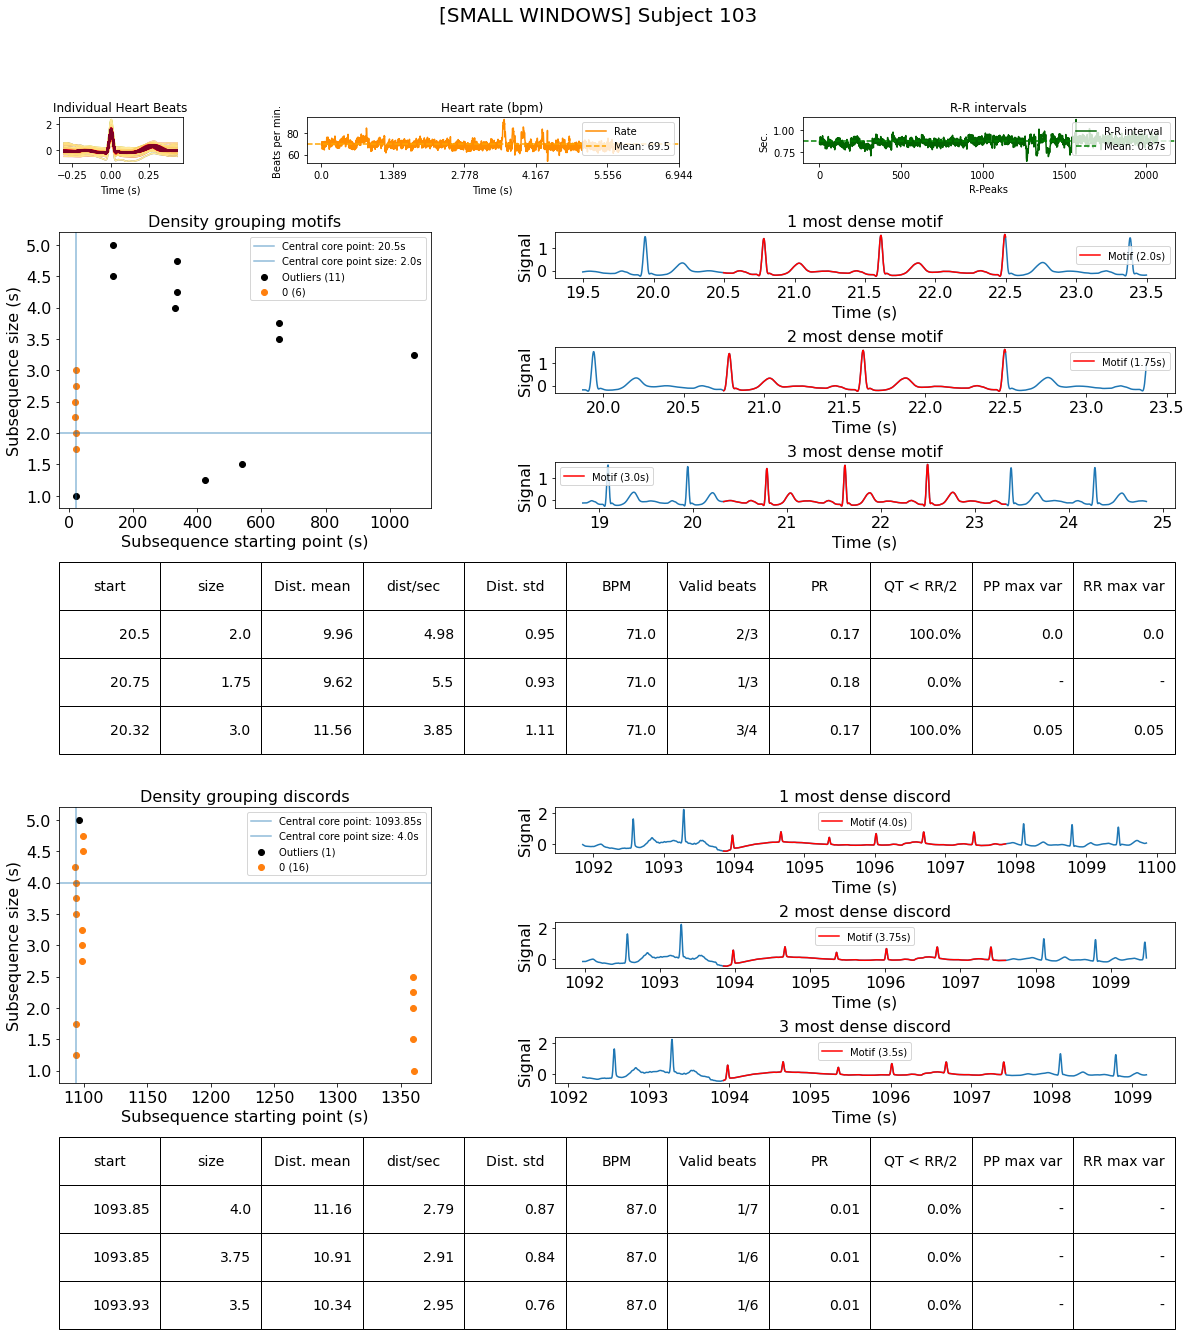

Computing MP using windows from 15.0s to 20.0s varying by 0.25s


100%|████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:04<00:00,  4.39it/s]


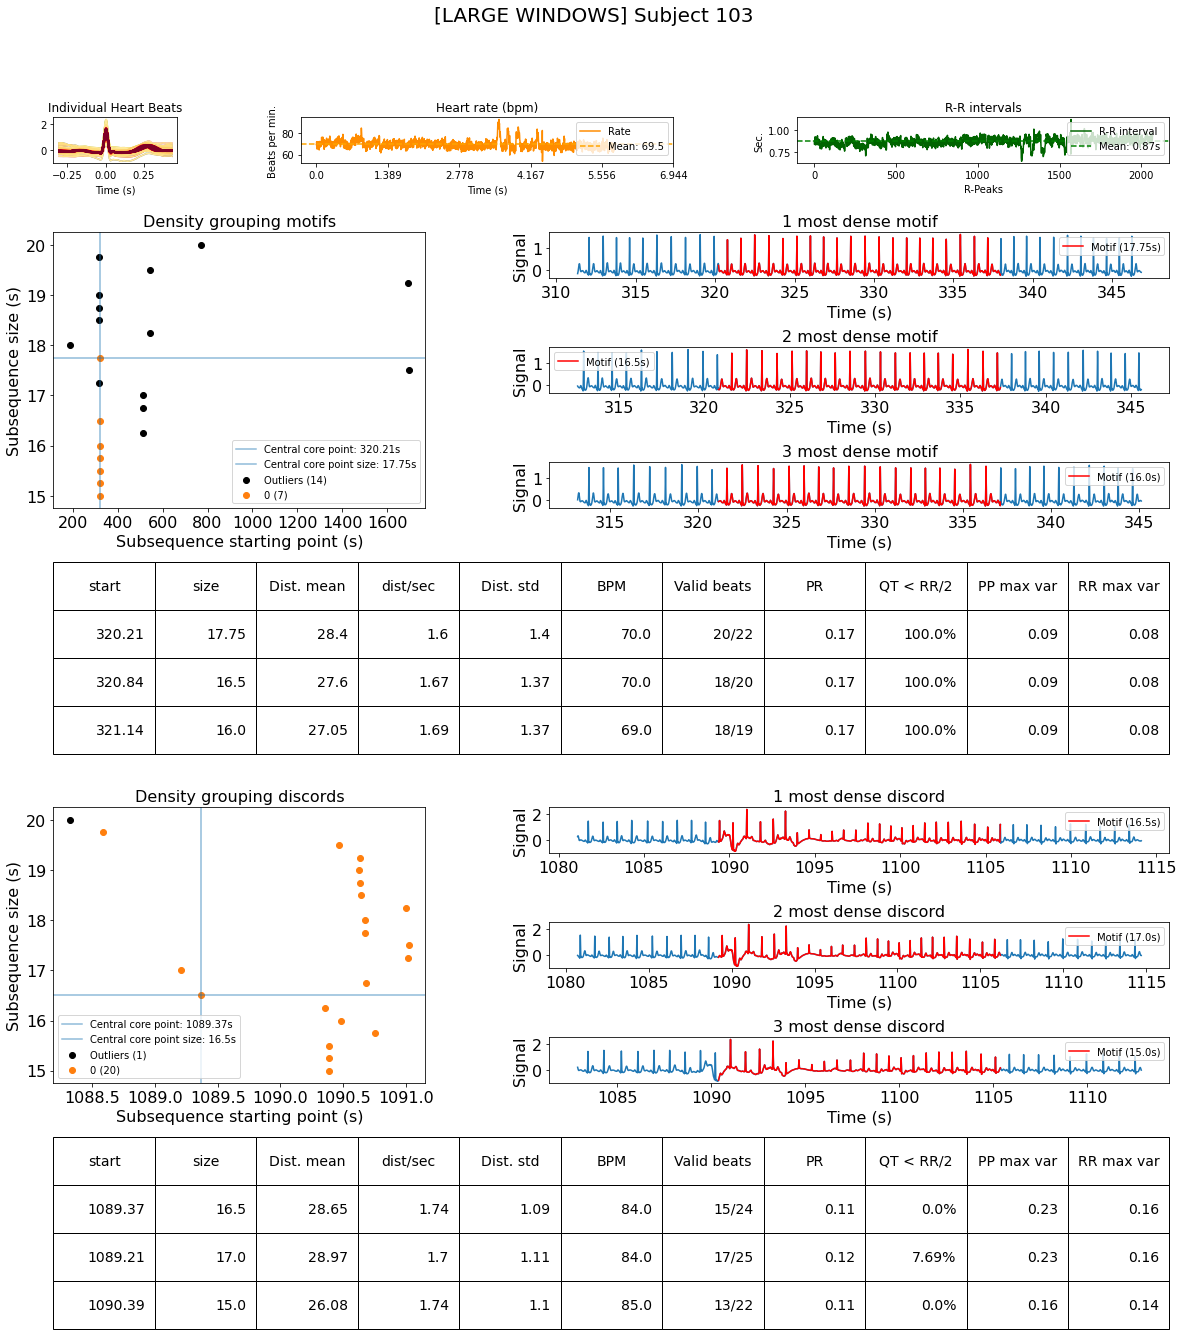

Running for subject 118
Computing MP using windows from 1.0s to 5.0s varying by 0.25s


100%|████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  4.14it/s]


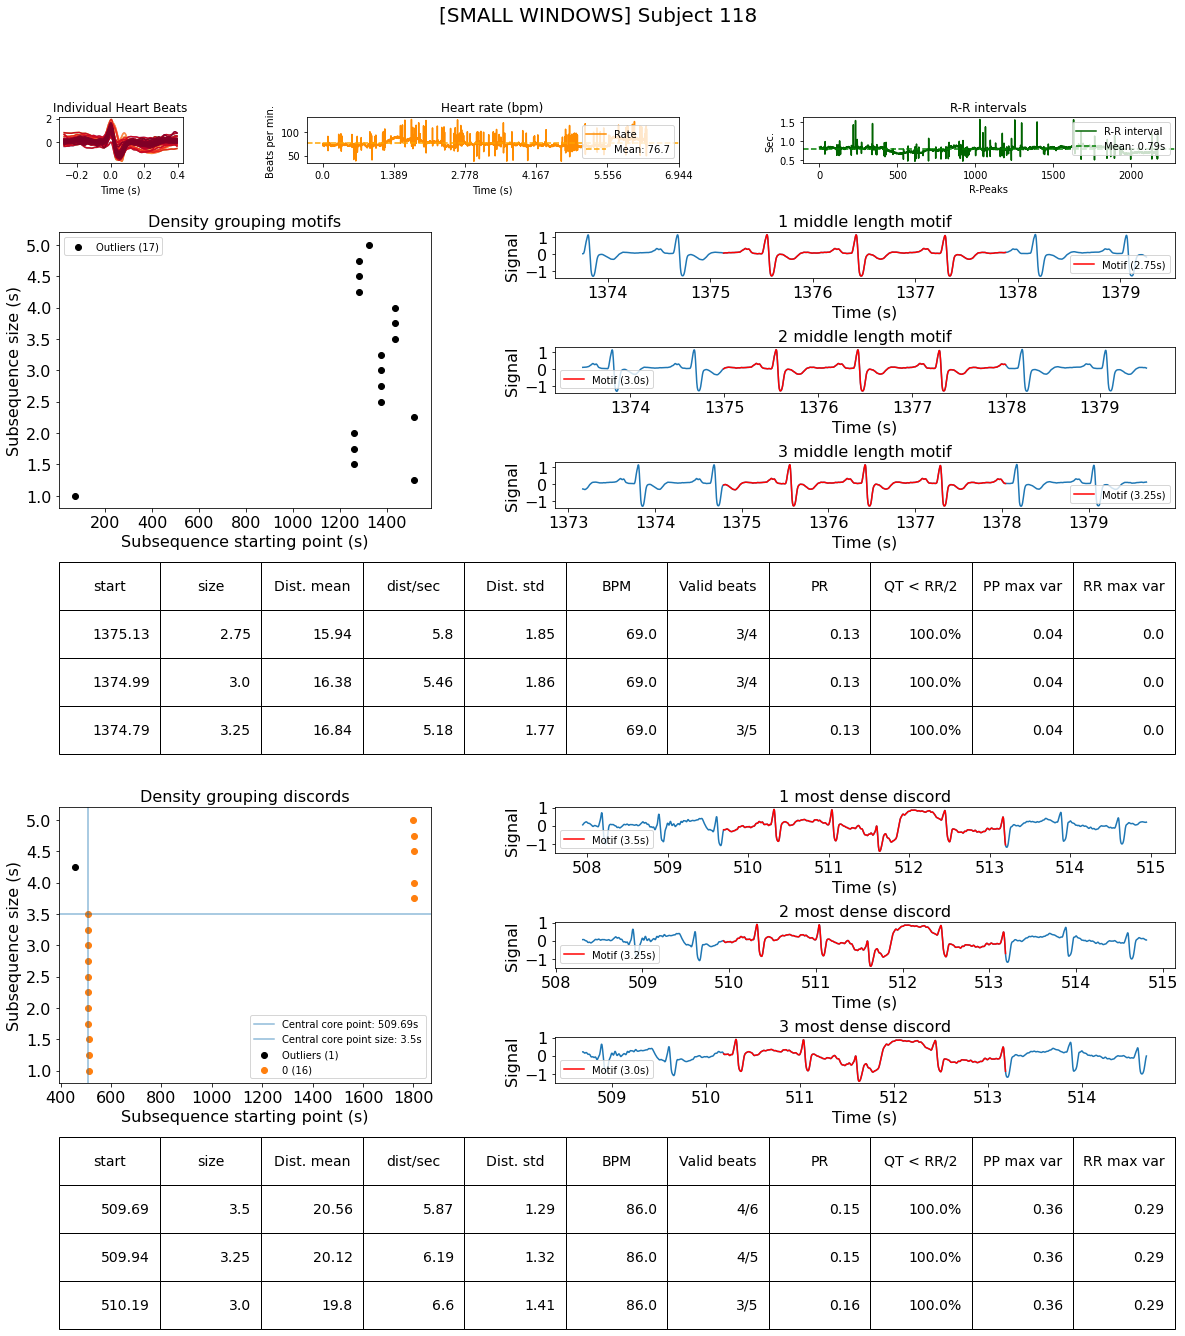

Computing MP using windows from 15.0s to 20.0s varying by 0.25s


100%|████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:04<00:00,  4.42it/s]


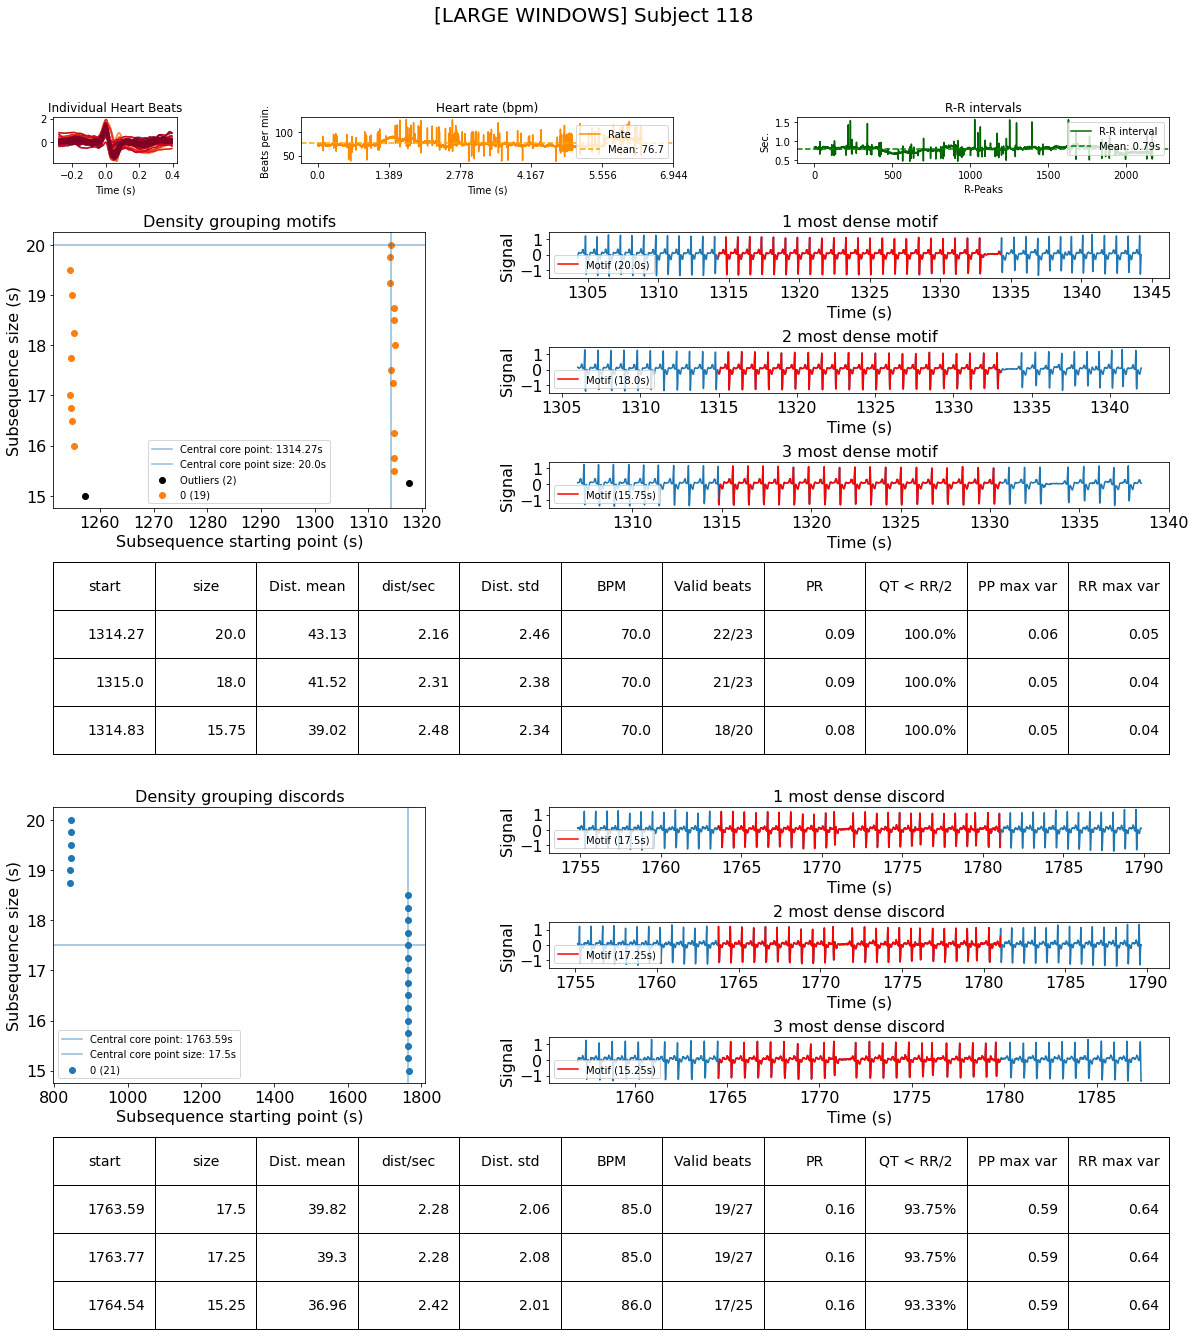

In [26]:
# Uncomment this to generate PDF artifacts
# %config InlineBackend.figure_formats = ['pdf']
mit_subjects = sorted(
    [int(f.split(".")[0]) \
         for f in list(walk("mit-bih-arrhythmia-database-1.0.0"))[0][2] if f.endswith(".dat")
    ]
)

# Uncomment this to explore a subset of subjects
mit_subjects = [103,118]

unidim_freq = 360

first_motifs_df = pd.DataFrame()
first_discords_df = pd.DataFrame()
overall_df = pd.DataFrame()

for sub in mit_subjects:
    print("Running for subject", sub)
    data = read_mit_ecg(sub)
    pre_computed_ecg = ECG(data, unidim_freq)
    
    L = int(1 * unidim_freq)
    U = 5 * unidim_freq
    STEP = int(0.25 * unidim_freq)
    
    caller = load_or_run_stump_wrapper_mit(sub)
    
    run_id = f"Subject {sub}"
    try:
        small_windows_result = compute_pmp(data, L, U, STEP, unidim_freq, caller)
        
        sum_dfs = run_pmp_plots(data, small_windows_result, unidim_freq, L, U, STEP, f"[SMALL WINDOWS] {run_id}", pre_computed_ecg=pre_computed_ecg)
        overall_df = pd.concat([overall_df] + [sum_dfs[k][["size", "Dist. mean"]] for k in sum_dfs])
        first_motifs_df = pd.concat([first_motifs_df,sum_dfs["motif"].head(1)])
        first_discords_df = pd.concat([first_discords_df,sum_dfs["discord"].head(1)]) 

        # run_pmp_plots(data, small_windows_result, unidim_freq, L, U, STEP, 
        #               f"[SMALL WINDOWS] {run_id} - Motifs", pre_computed_ecg=pre_computed_ecg, plot_discords=False)
        plt.show()
#         run_pmp_plots(data, small_windows_result, unidim_freq, L, U, STEP, 
#                       f"[SMALL WINDOWS] {run_id} - Discords", pre_computed_ecg=pre_computed_ecg, plot_motifs=False)
        
#         plt.show()
        
        # small_windows_result_mod = compute_pmp(data, L, U, STEP, unidim_freq, mod_caller)
        # run_pmp_plots(data, small_windows_result_mod, unidim_freq, L, U, STEP, f"[MODIFIED][SMALL WINDOWS] {run_id}", pre_computed_ecg=pre_computed_ecg)
        
    except Exception as e:
        print("Error:", e)
    plt.show()
        
        
    L = int(15 * unidim_freq)
    U = int(20 * unidim_freq)
    
    try:
        large_windows_result = compute_pmp(data, L, U, STEP, unidim_freq, caller)
        sum_dfs = run_pmp_plots(data, large_windows_result, unidim_freq, L, U, STEP, f"[LARGE WINDOWS] {run_id}", pre_computed_ecg=pre_computed_ecg)
        overall_df = pd.concat([overall_df] + [sum_dfs[k][["size", "Dist. mean"]] for k in sum_dfs])
        first_motifs_df = pd.concat([first_motifs_df,sum_dfs["motif"].head(1)])
        first_discords_df = pd.concat([first_discords_df,sum_dfs["discord"].head(1)])
        
        # run_pmp_plots(data, large_windows_result, unidim_freq, L, U, STEP, 
        #               f"[LARGE WINDOWS] {run_id} - Motifs", pre_computed_ecg=pre_computed_ecg, plot_discords=False)
        plt.show()
#         run_pmp_plots(data, large_windows_result, unidim_freq, L, U, STEP, 
#                       f"[LARGE WINDOWS] {run_id} - Discords", pre_computed_ecg=pre_computed_ecg, plot_motifs=False)
        
#         plt.show()
        # large_windows_result_mod = compute_pmp(data, L, U, STEP, unidim_freq, mod_caller)
        # run_pmp_plots(data, large_windows_result_mod, unidim_freq, L, U, STEP, f"[LARGE WINDOWS] {run_id}", pre_computed_ecg=pre_computed_ecg)

    except Exception as e:
        print("Error:", e)
    plt.show()
    
    # break
subj_col = np.full(2*len(mit_subjects), -1)
subj_col[range(0,2*len(mit_subjects),2)] = mit_subjects
subj_col[range(1,2*len(mit_subjects),2)] = mit_subjects
first_motifs_df["subject_id"] = subj_col
first_discords_df["subject_id"] = subj_col

In [41]:
first_motifs_df.to_csv("mit-first-motifs.csv", index=None)
first_discords_df.to_csv("mit-first-discords.csv", index=None)
overall_df.to_csv("mit-overall-distances.csv", index=None)

In [80]:
first_motifs_df = pd.read_csv("mit-first-motifs.csv")
first_discords_df = pd.read_csv("mit-first-discords.csv")
overall_df = pd.read_csv("mit-overall-distances.csv")

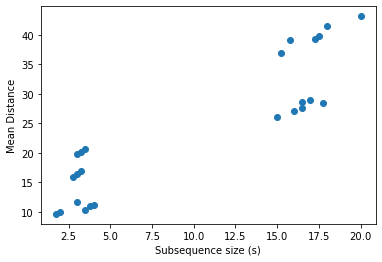

,size,Dist. mean
size,1.000000,0.900157
Dist. mean,0.900157,1.000000


In [27]:
plt.scatter(overall_df["size"], overall_df["Dist. mean"])
plt.xlabel("Subsequence size (s)")
plt.ylabel("Mean Distance")
plt.show()
overall_df.corr()

In [28]:
def fix_value(v):
    if pd.isna(v) or pd.isnull(v) or not type(v) == str:
        return v
    if "/" in v:
        a,b = v.split("/")
        if b == 0 or b.strip() == "":
            return 0
        else:
            return int(a)/int(b)
    elif v == "-":
        return np.nan
    elif v.endswith("%"):
        return float(v[:-1])/100
    if type(v) == str:
        try:
            return float(v)
        except Exception:
            return None

def fix_health_columns(in_df):
    df = in_df.copy()
    columns = ["Valid beats","PR", "QT < RR/2", "PP max var", "RR max var"]
    for c in columns:
        df[c] = df[c].apply(fix_value)
    return df
        
fix_first_motifs_df = fix_health_columns(first_motifs_df)
fix_first_discords_df = fix_health_columns(first_discords_df)

In [29]:
fix_first_motifs_df

,start,size,Dist. mean,dist/sec,Dist. std,BPM,Valid beats,PR,QT < RR/2,PP max var,RR max var,subject_id
0,20.50,2.00,9.96,4.98,0.95,71.0,0.666667,0.17,1.0,0.00,0.00,103
0,320.21,17.75,28.40,1.60,1.40,70.0,0.909091,0.17,1.0,0.09,0.08,103
0,1375.13,2.75,15.94,5.80,1.85,69.0,0.750000,0.13,1.0,0.04,0.00,118
0,1314.27,20.00,43.13,2.16,2.46,70.0,0.956522,0.09,1.0,0.06,0.05,118


In [30]:
# %config InlineBackend.figure_formats = ['pdf']
subset = fix_first_motifs_df.drop(["start", "subject_id", "size"],axis=1).columns
y_labels = {
    "BPM": "Beats per minute",
    "Valid beats": "Percentage",
    "PR": "seconds",
    "QT < RR/2": "Percentage",
    "PP max var": "seconds",
    "RR max var": "seconds",
}
alt_titles = {
    "Dist. mean": "Mean distance",
    "dist/sec": "Distance per second",
    "Dist. std": "Distance standard deviation",
    "PR": "PR interval"
}

plt.figure(figsize=(20,15))
for i,s in enumerate(subset):
    plt.subplot(3, 3, i+1)
    x = pd.DataFrame({"motifs": fix_first_motifs_df[s].astype(float), "discords": fix_first_discords_df[s].astype(float)})
    y_label = y_labels.get(s,"")
    if y_label == "Percentage":
        x = x * 100
    x.boxplot()
    # plt.boxplot(fix_first_motifs_df[s].dropna())
    # plt.boxplot(fix_first_discords_df[s].dropna())
    plt.title(alt_titles.get(s,s), fontsize=18)
    plt.ylabel(y_label, fontsize=15)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)

<Figure size 1440x1080 with 9 Axes>